In [10]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')

from utilities import DataLoggerUtility as dlu
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['axes.formatter.limits'] = [-2, 3]
plt.rcParams['axes.formatter.use_mathtext'] = True

In [11]:
datas = dlu.loadJSON('data/C127E/23-24/', 'GateSweep.json')

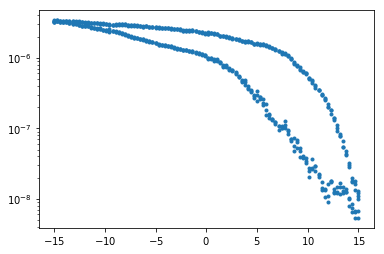

In [12]:
index = 10

plt.semilogy(datas[index]['voltage2s'], datas[index]['current1s'], '.')

plt.show()

### MOSFET Model

When $V_{GS} < V_{th}$:

$${\displaystyle I_{\text{D}}\approx I_{\text{D0}}e^{\frac {V_{\text{GS}}-V_{\text{th}}}{n \frac{k T}{q}}}}$$

Where

$${\displaystyle n=1+{\frac {C_{\text{dep}}}{C_{\text{ox}}}}}$$

When $V_{GS} > V_{th}$ and $V_{DS} < V_{GS} − V_{th}$:

$${\displaystyle I_{\text{D}}=\mu _{n}C_{\text{ox}}{\frac {W}{L}}\left(\left(V_{\text{GS}}-V_{th}\right)V_{\text{DS}}-{\frac {{V_{\text{DS}}}^{2}}{2}}\right)}$$

When $V_{GS} > V_{th}$ and $V_{DS} ≥ (V_{GS} – V_{th})$:

$${\displaystyle I_{\text{D}}={\frac {\mu _{n}C_{\text{ox}}}{2}}{\frac {W}{L}}\left[V_{\text{GS}}-V_{\text{th}}\right]^{2}\left[1+\lambda (V_{\text{DS}}-V_{\text{DSsat}})\right]}$$

We can replace $n$ by $SS$ using

$${\displaystyle SS=ln(10){kT \over q}(1+{C_{d} \over C_{ox}})}$$

So

$$ SS = ln(10) n V_{therm} $$

and

$$ n = \frac{SS}{ln(10) V_{therm}} $$

#### N-Type MOSFET Model Code

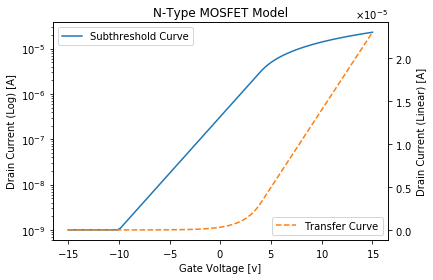

In [85]:
def MOSFETN_Drain_Current_Model_Point(VGS, VDS, ID0, Ioff, Vth, SS, lamb):
    kB = 8.617e-5
    T = 273.15 + 21
    q = 1
    Vtherm = kB*T/q
    n = SS/(np.log(10)*Vtherm)
    muCoxWoL = ID0/(n*VDS*Vtherm)*np.exp(1+VDS/(2*n*Vtherm))
    VcrossOver = n*Vtherm*np.log(n*Vtherm*muCoxWoL*VDS/ID0)
    Id = max(ID0*np.exp((VGS - Vth)/(n*Vtherm)), Ioff)
    if VGS > Vth + VcrossOver:
        if VDS < VGS - Vth:
            Id = muCoxWoL*((VGS - Vth)*VDS - VDS**2/2)
        else:
            Id = muCoxWoL*(VGS-Vth)**2*(1+lamb*(VDS-(VGS-Vth)))
    return Id

def MOSFETN_Drain_Current_Model(VGSs, VDS, ID0, Ioff, Vth, SS, lamb):
    return [MOSFETN_Drain_Current_Model_Point(VGS, VDS, ID0, Ioff, Vth, SS, lamb) for VGS in VGSs]

def MOSFETN_Drain_Current_Model_Log(VGSs, VDS, ID0, Ioff, Vth, SS, lamb):
    return [np.log(MOSFETN_Drain_Current_Model_Point(VGS, VDS, ID0, Ioff, Vth, SS, lamb)) for VGS in VGSs]

VGSs = np.linspace(-15,15,100)
Ids = MOSFETN_Drain_Current_Model(VGSs, 0.5, 1e-6, 1e-9, 2, 4, 1)

plt.title('N-Type MOSFET Model')
plt.xlabel('Gate Voltage [v]')
plt.ylabel('Drain Current [A]')
plt.ylabel('Drain Current (Log) [A]')
plt.semilogy(VGSs, Ids, label='Subthreshold Curve')
plt.legend(loc='upper left')
plt.twinx()
plt.plot([])
plt.plot(VGSs, Ids, '--', label='Transfer Curve')
plt.ylabel('Drain Current (Linear) [A]')
plt.legend(loc='lower right')
plt.show()

#### P-Type MOSFET Model Code

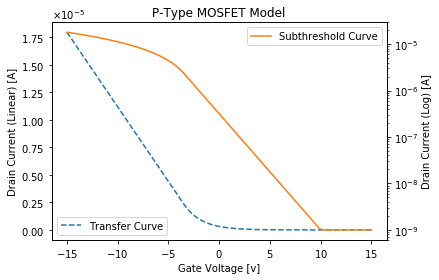

In [86]:
def MOSFETP_Drain_Current_Model_Point(VGS, VDS, ID0, Ioff, Vth, SS, lamb):
    kB = 8.617e-5
    T = 273.15 + 21
    q = 1
    Vtherm = kB*T/q
    n = -SS/(np.log(10)*Vtherm)
    muCoxWoL = ID0/(n*VDS*Vtherm)*np.exp(1+VDS/(2*n*Vtherm))
    VcrossOver = n*Vtherm*np.log(n*Vtherm*muCoxWoL*VDS/ID0)
    Id = max(ID0*np.exp((VGS - Vth)/(n*Vtherm)), Ioff)
    if VGS < Vth + VcrossOver:
        if VDS > VGS - Vth:
            Id = muCoxWoL*((VGS - Vth)*VDS - VDS**2/2)
        else:
            Id = muCoxWoL*(VGS-Vth)**2*(1+lamb*(VDS-(VGS-Vth)))
    return Id

def MOSFETP_Drain_Current_Model(VGSs, VDS, ID0, Ioff, Vth, SS, lamb):
    return [MOSFETP_Drain_Current_Model_Point(VGS, VDS, ID0, Ioff, Vth, SS, lamb) for VGS in VGSs]

def MOSFETP_Drain_Current_Model_Log(VGSs, VDS, ID0, Ioff, Vth, SS, lamb):
    return [np.log(MOSFETP_Drain_Current_Model_Point(VGS, VDS, ID0, Ioff, Vth, SS, lamb)) for VGS in VGSs]

VGSs = np.linspace(-15,15,100)
Ids = MOSFETP_Drain_Current_Model(VGSs, 0.5, 1e-6, 1e-9, -2, 4, 1)

plt.title('P-Type MOSFET Model')
plt.xlabel('Gate Voltage [v]')
plt.ylabel('Drain Current (Linear) [A]')
plt.plot(VGSs, Ids, '--', label='Transfer Curve')
plt.legend(loc='lower left')
plt.twinx()
plt.plot([])
plt.semilogy(VGSs, Ids, label='Subthreshold Curve')
plt.ylabel('Drain Current (Log) [A]')
plt.legend(loc='upper right')
plt.show()

### Fitting Model to Data



[  2.25428779e+00   2.08125518e-07   9.76828575e-09   5.66102497e+00
   5.47282881e+00   1.00000000e+00]


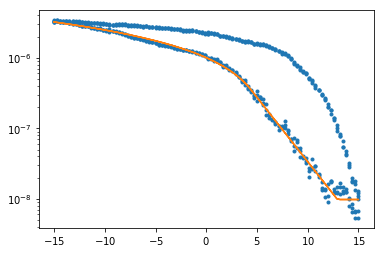

In [15]:
from scipy.optimize import curve_fit

fitCurrents = np.log(datas[index]['current1s'][0:len(datas[index]['current1s'])//2])
fitVoltages = datas[index]['voltage2s'][0:len(datas[index]['voltage2s'])//2]

popt, pcov = curve_fit(MOSFETP_Drain_Current_Model_Log, fitVoltages, fitCurrents,
                        bounds=([-40, 1e-14, 1e-16, -100, 1e-3, 0.9], [40, 1e-3, 1, 1e3, 1000, 1.1]), 
                        p0 = [0.5, 1e-6, 1e-9, -2, 4, 1])

print(popt)

plt.semilogy(datas[index]['voltage2s'], datas[index]['current1s'], '.')
plt.semilogy(datas[index]['voltage2s'], MOSFETP_Drain_Current_Model(datas[index]['voltage2s'], *popt))
plt.show()

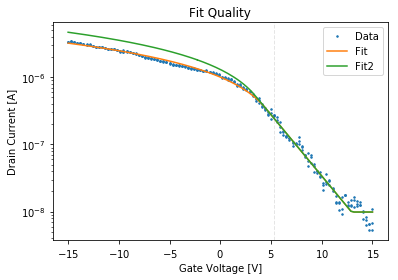

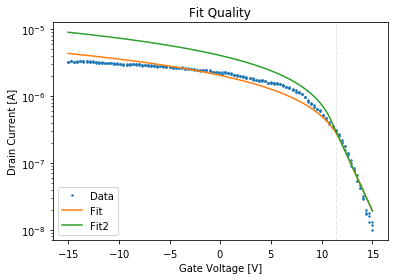

[{'ID0': 2.4796971792816891e-07,
  'Ioff': 9.8795721737943333e-09,
  'SS': 5.4883464576697722,
  'VDS': 1.1054679222698036,
  'Vth': 5.2608966533383921,
  'lamb': 1.0},
 {'ID0': 2.950132648733847e-07,
  'Ioff': 4.7178644385452734e-09,
  'SS': 3.0107696840436851,
  'VDS': 1.6095466162940024,
  'Vth': 11.422927150138833,
  'lamb': 1.0}]

In [89]:
from scipy.optimize import curve_fit

def Fit_MOSFETP_Drain_Current_Log(VGSs, Ids, sections=1, showPlots=False, showAllPlots=False):
    VGSsSections = np.array_split(VGSs, sections)
    IdsSections = np.array_split(Ids, sections)
    
    parameterNames = ['VDS', 'ID0', 'Ioff', 'Vth', 'SS', 'lamb']
    guesses = {'VDS':0.5, 'ID0':1e-6, 'Ioff':1e-9, 'Vth':-2, 'SS':1, 'lamb':1}
    
    results = []
    
    for VGSs, Ids in zip(VGSsSections, IdsSections):
        def simplestTransferModel(VGSs, Vth, gm):
            return np.maximum(gm*(VGSs - Vth), 0)
        
        (VthEstimate, gmEstimate), pcov = curve_fit(simplestTransferModel, VGSs, 
                                                    (Ids - min(Ids))/max(Ids), sigma=Ids/max(Ids))
        gmEstimate *= max(Ids)
        
        if showAllPlots:
            plt.plot(VGSs, Ids)
            plt.plot(VGSs, min(Ids) + simplestTransferModel(VGSs, VthEstimate, gmEstimate))
            plt.show()
        
        guesses['ID0'] = np.exp(0.6*max(np.log(Ids)) + 0.4*min(np.log(Ids)))
        guesses['Ioff'] = np.exp(np.percentile(np.log(Ids), 2))
        guesses['Vth'] = VthEstimate
        
        def simpleSubthresholdModelPoint(VGS, SS, Vth):
            kB = 8.617e-5
            T = 273.15 + 21
            q = 1
            Vtherm = kB*T/q
            n = -SS/(np.log(10)*Vtherm)
            if VGS < Vth:
                slope = -(max(Ids)-guesses['ID0'])
                return guesses['ID0'] + gmEstimate*(VGS-Vth)
            return max(guesses['Ioff'], guesses['ID0']*np.exp((VGS - Vth)/(n*Vtherm)))
        
        def simpleSubthresholdModelLog(VGSs, SS, Vth):
            return [np.log(simpleSubthresholdModelPoint(VGS, SS, Vth)) for VGS in VGSs]
        
        (SSEstimate, VthEstimate), pcov = curve_fit(simpleSubthresholdModelLog, VGSs, np.log(Ids),
                        bounds=([1e-3, -100], [1000, 100]),
                        p0 = [guesses['SS'], guesses['Vth']])
        
        guesses['SS'] = SSEstimate
        guesses['Vth'] = VthEstimate
        
        if showAllPlots:
            plt.plot(VGSs, np.log(Ids))
            plt.plot(VGSs, simpleSubthresholdModelLog(VGSs, SSEstimate, VthEstimate))
            plt.axvline(x=guesses['Vth'], linestyle='dashed', color='k', linewidth=1, alpha=0.1)
            plt.show()
        
        optParamVals, optParamCov = curve_fit(MOSFETP_Drain_Current_Model_Log, VGSs, np.log(Ids),
                        bounds = ([-40, 1e-14, 1e-16, -100, 1e-3, 0.9],
                                  [40, 1e-3, 1, 100, 1000, 1.1]), 
                        p0 = [guesses[parameterName] for parameterName in parameterNames])
        
        optParams = {}
        for parameterName, value in zip(parameterNames, optParamVals):
            optParams[parameterName] = value
        results.append(optParams)
        
        if showPlots:
            plt.semilogy(VGSs, Ids, '.', label='Data', markersize=3)
            #plt.semilogy(VGSs, MOSFETP_Drain_Current_Model(VGSs, **guesses), label='Guess')
            plt.semilogy(VGSs, MOSFETP_Drain_Current_Model(VGSs, **optParams), label='Fit')
            optParams['VDS'] -= 2
            plt.semilogy(VGSs, MOSFETP_Drain_Current_Model(VGSs, **optParams), label='Fit2')
            plt.axvline(x=optParams['Vth'], linestyle='dashed', color='k', linewidth=1, alpha=0.1)
            plt.title('Fit Quality')
            plt.xlabel('Gate Voltage [V]')
            plt.ylabel('Drain Current [A]')
            plt.legend()
            plt.show()
    
    return results

Fit_MOSFETP_Drain_Current_Log(datas[index]['voltage2s'], datas[index]['current1s'], 2, showPlots=True)

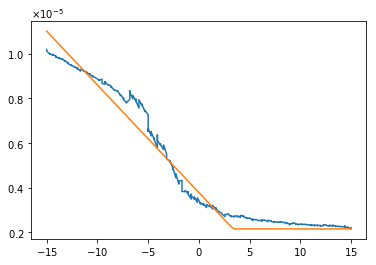

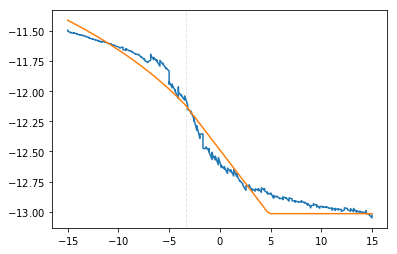

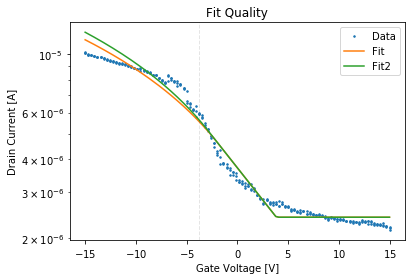

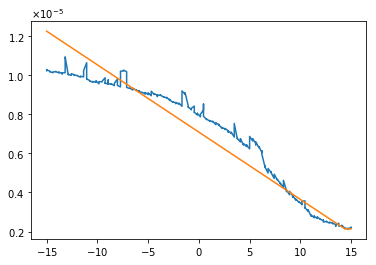

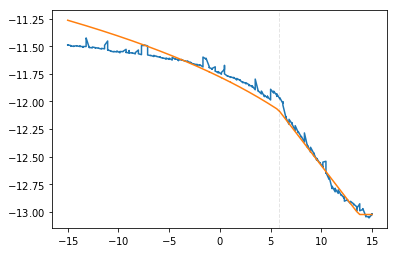

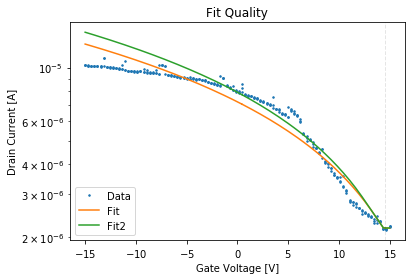

[{'ID0': 5.6563439777999296e-06,
  'Ioff': 2.4003763475214942e-06,
  'SS': 20.43812198816082,
  'VDS': 19.42871571080029,
  'Vth': -3.7601385979452897,
  'lamb': 1.0},
 {'ID0': 2.1435701809685423e-06,
  'Ioff': 2.177101525087572e-06,
  'SS': 16.338820275177412,
  'VDS': 10.027772122218908,
  'Vth': 14.513892316037834,
  'lamb': 1.0}]

In [90]:
Fit_MOSFETP_Drain_Current_Log(datas[1]['voltage2s'], datas[1]['current1s'], 2, showPlots=True, showAllPlots=True)

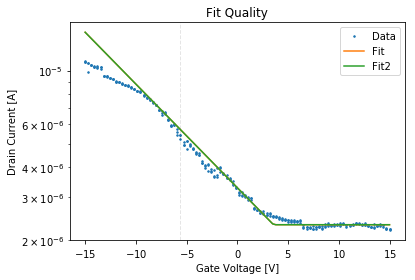

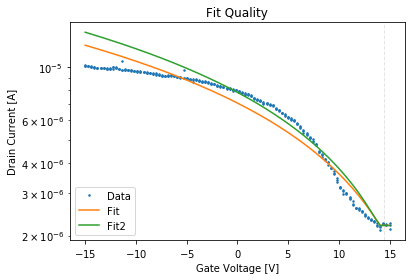

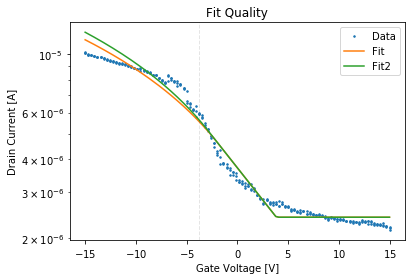

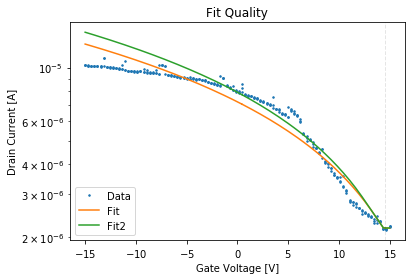

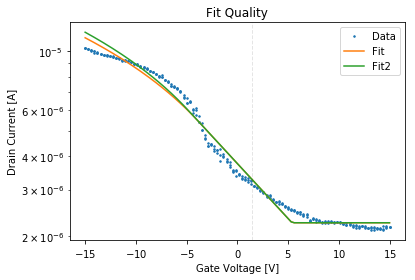

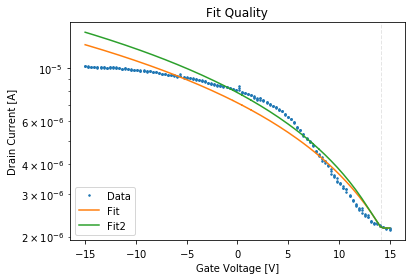

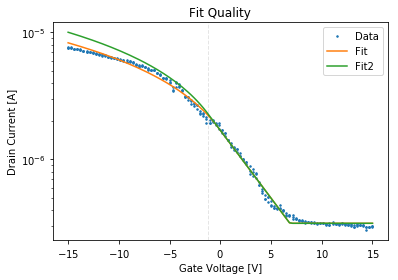

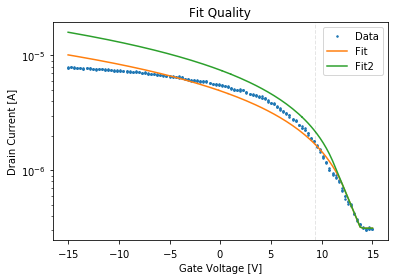

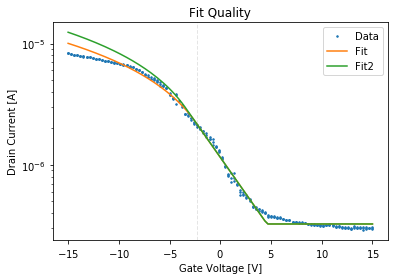

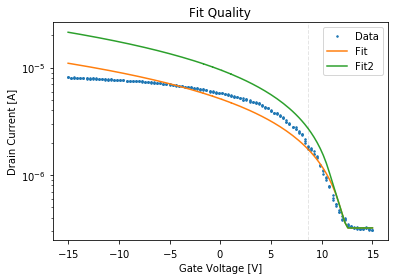

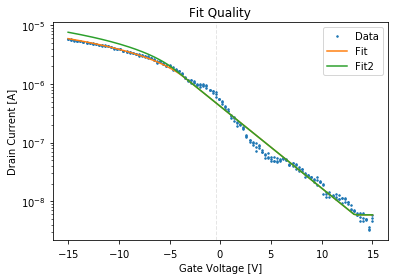

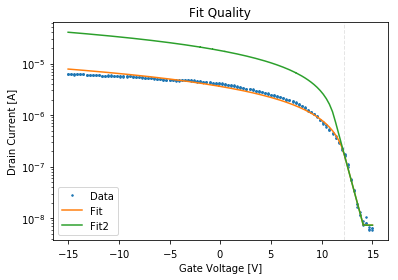

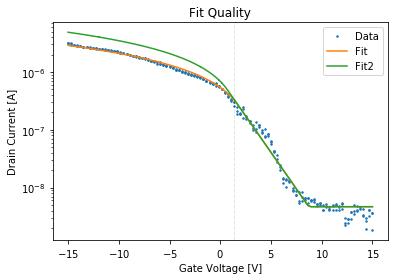

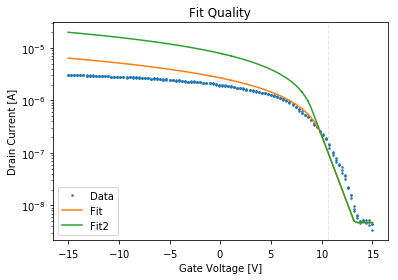

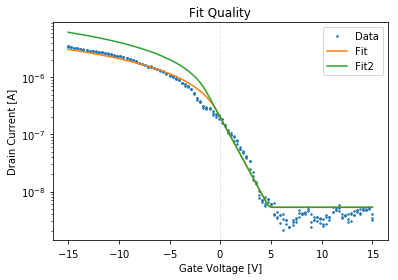

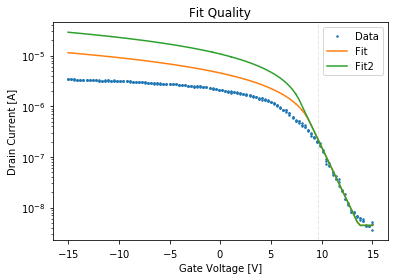

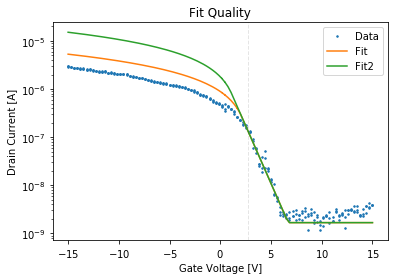

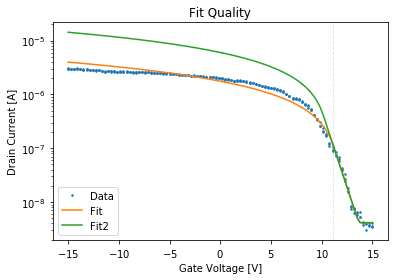

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [91]:
for i in range(len(datas)):
    Fit_MOSFETP_Drain_Current_Log(datas[i]['voltage2s'], datas[i]['current1s'], 2, showPlots=True)